In [6]:
import rebound
import numpy as np

In [7]:
import os

os.environ["https_proxy"] = "http://localhost:49490"
os.environ["http_proxy"] = "http://localhost:49490"
os.environ["all_proxy"] = "socks5://localhost:49490"
os.environ["HTTPS_PROXY"] = "http://localhost:49490"
os.environ["HTTP_PROXY"] = "http://localhost:49490"
os.environ["ALL_PROXY"] = "socks5://localhost:49490"

In [8]:

import rebound
import time

%load_ext autoreload
%autoreload 2

from utils import (
    retry_on_exception,
    sim_logger,
    fetch_solar_system_bodies
)

sim_logger.setLevel("DEBUG")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
new_celestials = fetch_solar_system_bodies()

import json

# Convert the dictionary to a JSON string with maximum precision
json_str = json.dumps(new_celestials, ensure_ascii=False, indent=4, separators=(',', ':'), sort_keys=False, default=lambda x: format(x, ".15g"))

# Save to a JSON file
with open("solar_system_data.json", "w") as file:
    file.write(json_str) 

In [18]:
import json

celestial_bodies = json.load(open("solar_system_data.jsonl", "r"))

In [20]:

next(iter(celestial_bodies.values()))
# add up all the masses
total_mass = sum([body["m"] for body in celestial_bodies.values()])
total_mass

1.0013418309074729

In [ ]:
def nbody_simulation_3d(celestial_bodies,
               tmax=1e4,
               dt=1e-2, 
               integrator="whfast",
               collision="direct",
               collision_resolve="merge",
               filename="rebound.bin"):
    
    sim = rebound.Simulation()
    sim.units = ("yr", "AU", "Msun")
    sim.integrator = integrator
    sim.dt = dt
    sim.add(celestial_bodies.values())
    
    # move to the center of mass frame
    sim.move_to_com()
    
    sim.automateSimulationArchive(filename, interval=1e3, deletefile=True)
    
    sim.exit_min_distance = 0.01
    
    # collision detection
    sim.collision = "direct"
    sim.collision_resolve = "merge"
    sim.collision_resolve_keep_sorted = 1
    sim.collision_resolve_keep_sorted = 1
    sim.collision_resolve

In [21]:
import numpy as np
import scipy
solve_ivp = scipy.integrate.solve_ivp
import os, sys

In [ ]:
# ##### ENERGY #####
# def potential_energy(state):
#     '''U=\sum_i,j>i G m_i m_j / r_ij'''
#     tot_energy = np.zeros((1,1,state.shape[2]))
#     for i in range(state.shape[0]):
#         for j in range(i+1,state.shape[0]):
#             r_ij = ((state[i:i+1,1:3] - state[j:j+1,1:3])**2).sum(1, keepdims=True)**.5
#             m_i = state[i:i+1,0:1]
#             m_j = state[j:j+1,0:1]
#             tot_energy += m_i * m_j / r_ij
#     U = -tot_energy.sum(0).squeeze()
#     return U


# def kinetic_energy(state):
#     '''T=\sum_i .5*m*v^2'''
#     energies = .5 * state[:,0:1] * (state[:,3:5]**2).sum(1, keepdims=True)
#     T = energies.sum(0).squeeze()
#     return T


# def total_energy(state):
#     return potential_energy(state) + kinetic_energy(state)

##### DYNAMICS #####
def get_accelerations(state, epsilon=0):
    # shape of state is [bodies x properties]
    net_accs = [] # [nbodies x 2]
    for i in range(state.shape[0]): # number of bodies
        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
        displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
        distances = (displacements**2).sum(1, keepdims=True)**0.5
        masses = other_bodies[:, 0:1] # index 0 -> mass
        pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1
        net_acc = pointwise_accs.sum(0, keepdims=True)
        net_accs.append(net_acc)
    net_accs = np.concatenate(net_accs, axis=0)
    return net_accs
  
def update(t, state):
    state = state.reshape(-1,5) # [bodies, properties]
    deriv = np.zeros_like(state)
    deriv[:,1:3] = state[:,3:5] # dx, dy = vx, vy
    deriv[:,3:5] = get_accelerations(state)
    return deriv.reshape(-1)

In [ ]:
##### INTEGRATION SETTINGS #####
def get_orbit(state, update_fn=update, t_points=100, t_span=[0,2], nbodies=3, **kwargs):
    if not 'rtol' in kwargs.keys():
        kwargs['rtol'] = 1e-9

    orbit_settings = locals()

    nbodies = state.shape[0]
    t_eval = np.linspace(t_span[0], t_span[1], t_points)
    orbit_settings['t_eval'] = t_eval

    path = solve_ivp(fun=update_fn, t_span=t_span, y0=state.flatten(),
                     t_eval=t_eval, **kwargs)
    orbit = path['y'].reshape(nbodies, 5, t_points)
    return orbit, orbit_settings

In [ ]:
##### INITIALIZE THE TWO BODIES #####
def rotate2d(p, theta):
  c, s = np.cos(theta), np.sin(theta)
  R = np.array([[c, -s],[s, c]])
  return (R @ p.reshape(2,1)).squeeze()

def random_config(nu=2e-1, min_radius=0.9, max_radius=1.2):
  '''This is not principled at all yet'''
  state = np.zeros((3,5))
  state[:,0] = 1
  p1 = 2 * np.random.rand(2) - 1 # random position in [-1,1] x [-1,1]
  r = np.random.rand() * (max_radius-min_radius) + min_radius
  
  p1 *= r/np.sqrt( np.sum((p1**2)) )
  p2 = rotate2d(p1, theta=2*np.pi/3)
  p3 = rotate2d(p2, theta=2*np.pi/3)

  # # velocity that yields a circular orbit
  v1 = rotate2d(p1, theta=np.pi/2)
  v1 = v1 / r**1.5
  v1 = v1 * np.sqrt(np.sin(np.pi/3)/(2*np.cos(np.pi/6)**2)) # scale factor to get circular trajectories
  v2 = rotate2d(v1, theta=2*np.pi/3)
  v3 = rotate2d(v2, theta=2*np.pi/3)
  
  # make the circular orbits slightly chaotic
  v1 *= 1 + nu*(2*np.random.rand(2) - 1)
  v2 *= 1 + nu*(2*np.random.rand(2) - 1)
  v3 *= 1 + nu*(2*np.random.rand(2) - 1)

  state[0,1:3], state[0,3:5] = p1, v1
  state[1,1:3], state[1,3:5] = p2, v2
  state[2,1:3], state[2,3:5] = p3, v3
  return state

In [ ]:
##### INTEGRATE AN ORBIT OR TWO #####
def sample_orbits(timesteps=20, trials=5000, nbodies=3, orbit_noise=2e-1,
                  min_radius=0.9, max_radius=1.2, t_span=[0, 5], verbose=False, **kwargs):
    
    orbit_settings = locals()
    if verbose:
        print("Making a dataset of near-circular 3-body orbits:")
    
    x, dx, e = [], [], []
    N = timesteps * trials
    while len(x) < N:

        state = random_config(nu=orbit_noise, min_radius=min_radius, max_radius=max_radius)
        orbit, settings = get_orbit(state, t_points=timesteps, t_span=t_span, nbodies=nbodies, **kwargs)
        batch = orbit.transpose(2,0,1).reshape(-1,nbodies*5)
        
        for state in batch:
            dstate = update(None, state)
            
            # reshape from [nbodies, state] where state=[m, qx, qy, px, py]
            # to [canonical_coords] = [qx1, qx2, qy1, qy2, px1,px2,....]
            
            coords = state.reshape(nbodies,5).T[1:].flatten()
            x.append(coords)

    data = {'coords': np.stack(x)[:N]}
    
    return data, orbit_settings

In [ ]:
# import numpy as np

# def initialize_solar_system(n=9, sun_mass=1e6, min_dist=0.9, max_dist=1.2, nu=2e-1):
#     '''Initialize a mock solar system with n bodies'''
    
#     # Initial state [m, vx, vy, vz, x, y, z]
#     state = np.zeros((n, 7))
    
#     # Set the Sun at the center with a large mass and zero velocity
#     state[0, 0] = sun_mass  # Sun's mass
#     state[0, 4:7] = 0  # Sun's position

#     for i in range(1, n):
#         # Set mass (considerably less than the Sun)
#         state[i, 0] = 1  # Example mass; can be randomized
        
#         # Random distance from the Sun
#         r = np.random.rand() * (max_dist - min_dist) + min_dist
        
#         # Random position in 3D space but at distance r from Sun
#         rand_dir = np.random.randn(3)  # Random direction
#         rand_dir /= np.linalg.norm(rand_dir)  # Normalize to unit vector
#         state[i, 4:7] = r * rand_dir
        
#         # Velocity for roughly circular orbit, perturbed slightly for randomness
#         v = np.cross([0, 0, 1], state[i, 4:7])
#         v /= np.linalg.norm(v)
#         v *= np.sqrt(sun_mass / r**3)
        
#         # Make orbits slightly chaotic
#         v *= 1 + nu*(2*np.random.rand(3) - 1)
#         state[i, 1:4] = v

#     return state

In [ ]:
data = sample_orbits(timesteps=200, trials=5, nbodies=3, orbit_noise=2e-1, min_radius=0.9, max_radius=1.2, t_span=[0, 5], verbose=True)

# print(data.keys())
# print(data['coords'].shape)
# print(data['dcoords'].shape)
# print(data['energy'].shape)
# print(data['meta'])

In [13]:
import json

celestial_bodies = json.load(open("solar_system_data.json", "r"))

In [1]:
from dataclasses import dataclass, field, asdict
from typing import Optional
import rebound
import hashlib
import numpy as np
import os 

@dataclass
class SimConfig:
    celestial_init_states: dict
    dt: float = 1e-1
    units: tuple = ("yr", "AU", "Msun")
    integrator: str = "whfast"
    record_steps: int = 1
    theory: Optional[str] = field(default=None)
    filename: Optional[str] = field(default=None)
    
    def __post_init__(self):
        default_svae_dir = os.path.join(os.getcwd(), "data/simulations")
        os.makedirs(default_svae_dir, exist_ok=True)
        
        if not self.filename:
            setting_str = str(asdict(self))
            hash_obj = hashlib.sha256(setting_str.encode())
            self.filename = os.path.join(default_svae_dir, f"sim_{hash_obj.hexdigest()}.bin")


def init_simulation(config: SimConfig):
    sim = rebound.Simulation()
    sim.units = config.units
    sim.integrator = config.integrator
    sim.dt = config.dt
    
    for key, body in config.celestial_init_states.items():
        sim.add(**body)
    
    # Move to the center of mass frame
    sim.move_to_com()
    
    sim.automateSimulationArchive(config.filename, step=config.record_steps, deletefile=True)
    
    return sim

def run_simulation(sim, tmax):
    print(f"Running simulation for {tmax} years, each step is {sim.dt} years")
    print(f"Totally steps: {int(tmax/sim.dt) + 1} (including initial step)")
    sim.integrate(tmax)
    return sim

def particle_to_dict(particle: rebound.Particle):
    m = particle.m
    x, y, z = particle.xyz
    vx, vy, vz = particle.vxyz
    return {"m": m, "x": x, "y": y, "z": z, "vx": vx, "vy": vy, "vz": vz}

def stack_positions_or_velocities(data: dict, keys: list[str] = ["x", "y", "z"]):
    # name: celestial body name
    return np.stack([np.column_stack([data[name][k] for k in keys]) for name in list(data.keys())], axis=0)

In [2]:
import json

position_axes = ["x", "y", "z"]
velocity_axes = ["vx", "vy", "vz"]

celestial_init_states = json.load(open("solar_system_data.json", "r"))
celestial_masses = [body["m"] for body in celestial_init_states.values()]
celestial_names = [body for body in celestial_init_states.keys()]

config = SimConfig(celestial_init_states, dt=0.1, record_steps=1)
sim = init_simulation(config)
sim = run_simulation(sim, tmax=2e2)
del sim

sim_archive = rebound.SimulationArchive(config.filename)
sample_idxs = generate_sample_idxs(n_samples, len(sim_archive), interval="equal")
sample_snapshots = [sim_archive[i] for i in sample_idxs]

celestial_names = [body for body in config.celestial_init_states.keys()]

# Extract data from snapshots
snapshots_data = [{name: particle_to_dict(body) for name, body in zip(celestial_names, snapshot.particles)} 
                for snapshot in sample_snapshots]

# Initialize data structures for positions and velocities
celestial_positions = {name: {axis: [] for axis in position_axes} for name in celestial_names}
celestial_velocities = {name: {axis: [] for axis in velocity_axes} for name in celestial_names}

# Populate data structures with data from snapshots
for snapshot in snapshots_data:
    for name in celestial_names:
        for p_axis, v_axis in zip(position_axes, velocity_axes):
            celestial_positions[name][p_axis].append(snapshot[name][p_axis])
            celestial_velocities[name][v_axis].append(snapshot[name][v_axis])

# stack the positions and velocities as numpy arrays [nbodies, nsteps, axes]
orbit_positions_np = stack_positions_or_velocities(celestial_positions, position_axes)
orbit_velocities_np = stack_positions_or_velocities(celestial_velocities, velocity_axes)

NameError: name 'celestial_bodies' is not defined

In [160]:
orbit_positions_np.shape, orbit_velocities_np.shape

((9, 64, 3), (9, 64, 3))

In [161]:
orbit_coord_metadata = {
    'celestial_names': celestial_names,
    'celestial_masses': celestial_masses,
    'simulation_config': asdict(config),
    'time_step': 64,
    'axes': ['x', 'y', 'z'],
    # 'data_format': "name x time_step x position_xyz",
}

# save 
orbits_save_dir = os.path.join(os.getcwd(), "data/orbit_coordinates")
os.makedirs(orbits_save_dir, exist_ok=True)
orbits_save_path = os.path.join(orbits_save_dir, config.filename.split("/")[-1].replace(".bin", ".npz"))
np.savez_compressed(orbits_save_path, data=orbit_positions_np, metadata=orbit_coord_metadata)

In [162]:
def isolate_neptune(celestial_names, celestial_masses, orbit_positions_np):
    neptune_idx = celestial_names.index("Neptune")
    neptune_mass = celestial_masses[neptune_idx]
    neptune_orbit = orbit_positions_np[neptune_idx]
    rest_orbit = np.delete(orbit_positions_np, neptune_idx, axis=0)
    return neptune_orbit, rest_orbit

In [155]:
np.load('data_with_metadata.npz', allow_pickle=True)['metadata'].item()

{'celestial_names': ['Sun',
  'Mercury',
  'Venus',
  'Earth',
  'Mars',
  'Jupiter',
  'Saturn',
  'Uranus',
  'Neptune'],
 'celestial_masses': [0.9999999999950272,
  1.6601208254808336e-07,
  2.447838287784771e-06,
  3.0404326489511185e-06,
  3.2271560828978514e-07,
  0.0009547919099366768,
  0.0002858856700231729,
  4.366249613200406e-05,
  5.151383772628957e-05],
 'simulation_config': {'celestial_init_states': {'Sun': {'m': 0.9999999999950272,
    'x': -0.008275095945775721,
    'y': -0.0024128761991964115,
    'z': 0.00021289244521150222,
    'vx': 0.001563217462366331,
    'vy': -0.002798341397345918,
    'vz': -1.189654501477506e-05},
   'Mercury': {'m': 1.6601208254808336e-07,
    'x': -0.32887190074636113,
    'y': -0.3149112646388192,
    'z': 0.004081716549750979,
    'vx': 5.081866262775413,
    'vy': -6.894586437998819,
    'vz': -1.029202836209595},
   'Venus': {'m': 2.447838287784771e-06,
    'x': 0.1478769199764277,
    'y': 0.7009190768704976,
    'z': 0.00086193613124

In [134]:
orbit_positions_np["Sun"]

{'x': array([-0.0082751 , -0.00088025,  0.00053248, -0.0046398 , -0.00189898,
         0.00625588,  0.00437668, -0.00363155, -0.0021695 ,  0.00291941,
        -0.00110451, -0.00662596, -0.00025297,  0.00672565,  0.00296187,
        -0.00163767,  0.00365981,  0.00555033, -0.00236527, -0.0064503 ,
         0.00054731,  0.00327252, -0.00188269, -0.00101833,  0.00718072,
         0.00661873, -0.00174355, -0.00198646,  0.00370718,  0.00104158,
        -0.00513259, -0.00011712,  0.00791209,  0.00534248, -0.00034092,
         0.0038696 ,  0.00693175, -0.0002583 , -0.00598235,  0.00011854,
         0.00392535, -0.00110829, -0.00231078,  0.00528642,  0.00573494,
        -0.00299725, -0.00537551,  0.00021702, -0.00137119, -0.00819278,
        -0.00499275,  0.00362687,  0.00233414, -0.00406326, -0.00100578,
         0.00340763, -0.00229929, -0.00871901, -0.00302095,  0.00268647,
        -0.00092243, -0.00296756,  0.00474258,  0.00720896]),
 'y': array([-2.41287620e-03, -4.97068720e-03,  3.3460418

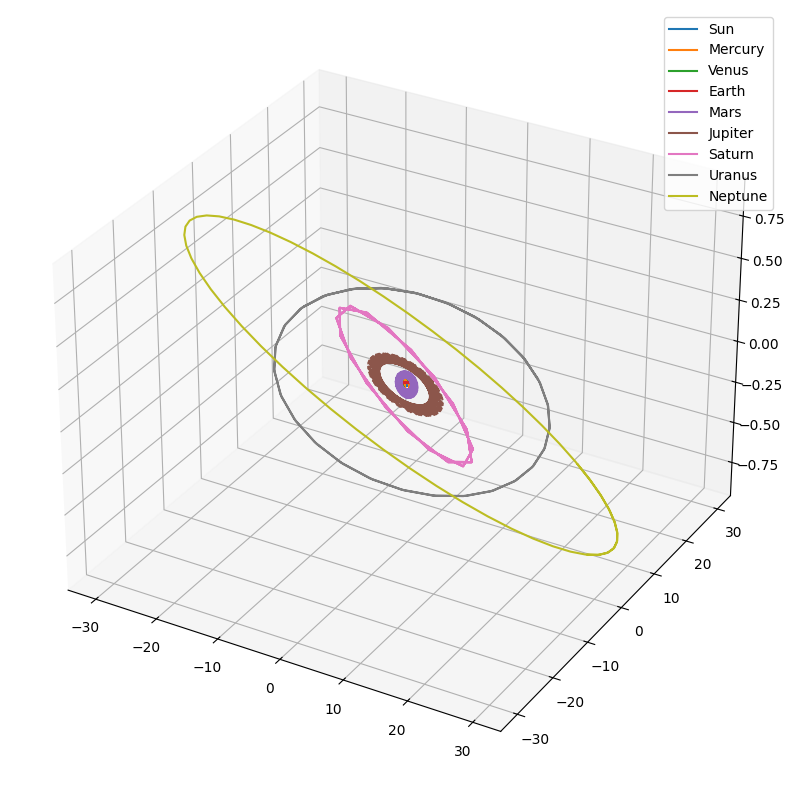

In [131]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for name, pos in orbit_positions.items():
    ax.plot(pos["x"], pos["y"], pos["z"], label=name)
ax.legend()
plt.show()

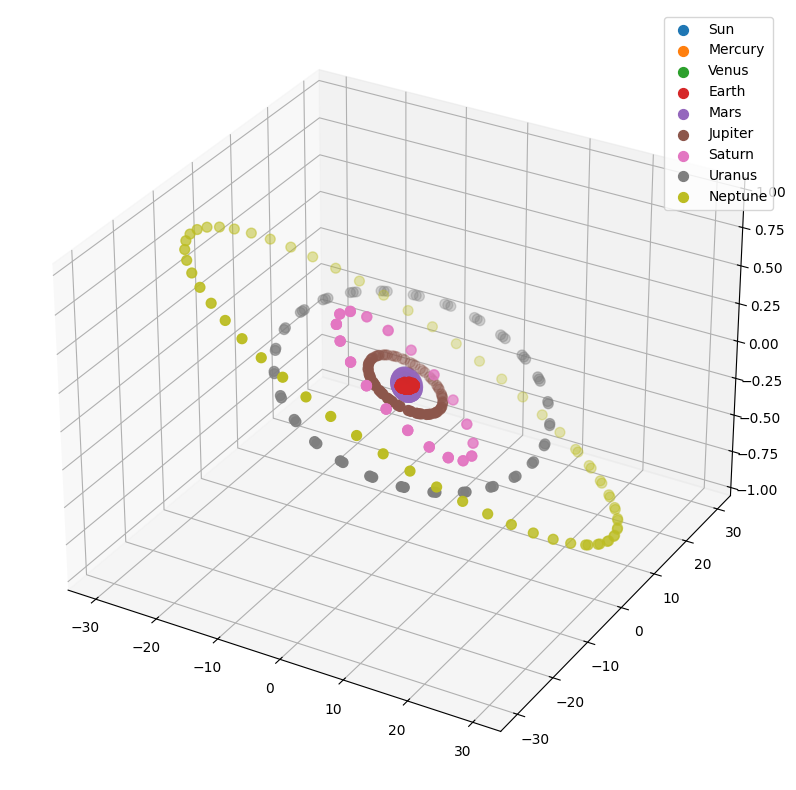

In [132]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Assuming orbit_positions is a dictionary containing positions for each celestial body
for name, pos in orbit_positions.items():
    ax.scatter(pos["x"], pos["y"], pos["z"], label=name, s=50)  # s is the marker size

ax.legend()
plt.show()


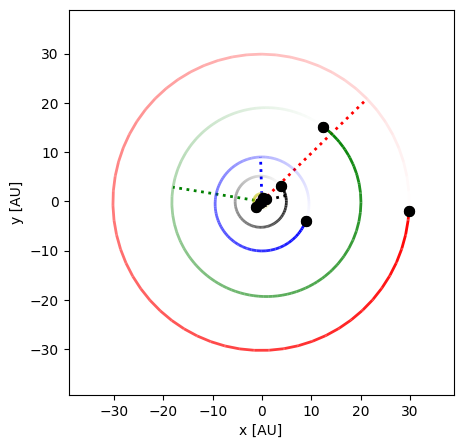

In [80]:
plot = rebound.OrbitPlot(sample_snapshots[0], unitlabel="[AU]", color=True, periastron=True, lw=2)

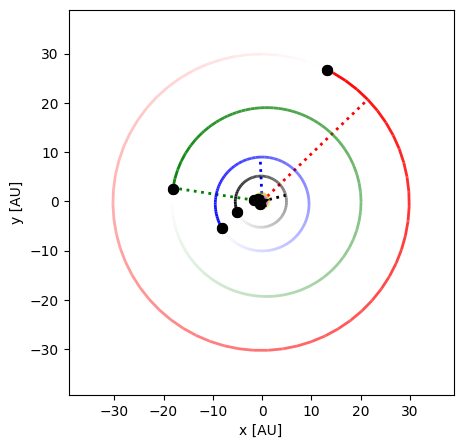

In [82]:
plot = rebound.OrbitPlot(sample_snapshots[63], unitlabel="[AU]", color=True, periastron=True, lw=2)

118000